In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os
import librosa 
from librosa.display import specshow
import tqdm 
import scipy
from copy import deepcopy
import skimage.io as io
%matplotlib inline

In [10]:
os.path.expanduser('~/Users/phinchosherpa/Desktop/nyu/BirdVox-15min')
wav_path='/Users/phinchosherpa/Desktop/nyu/BirdVox-15min'

In [2]:
def acoustic_features(wav_path, verbose=False):
    hop_length = 32
    n_fft = 256
    n_features = 1 + (n_fft // 2)
    chunk_duration = 10 # in seconds
    
    y, sr = librosa.load(wav_path)
    chunk_length = chunk_duration * sr
    chunk_hop_length = int(chunk_length * 0.5)
    y_chunks = librosa.util.frame(
        y, frame_length=chunk_length, hop_length=chunk_hop_length)
    n_chunks = y_chunks.shape[1]
    
    X_dict = {
        "average_energy": np.full((n_features, n_chunks), np.float32(np.nan)),
        "maximum_energy": np.full((n_features, n_chunks), np.float32(np.nan)),
        "maximum_spectral-flux": np.full((n_features, n_chunks), np.float32(np.nan)),
        "acoustic-complexity-index": np.full((n_features, n_chunks), np.float32(np.nan)),
        "negative-entropy": np.full((n_features, n_chunks), np.float32(np.nan)),
        "maximum_weighted-phase-deviation": np.full((n_features, n_chunks), np.float32(np.nan)),
        "maximum_pcen-flux_longdistance": np.full((n_features, n_chunks), np.float32(np.nan)),
        "maximum_pcen-flux_birdvoxdetect": np.full((n_features, n_chunks), np.float32(np.nan)),
        "maximum_pcen_longdistance": np.full((n_features, n_chunks), np.float32(np.nan)),
        "maximum_pcen_birdvoxdetect": np.full((n_features, n_chunks), np.float32(np.nan))
    }
    
    for chunk_id in tqdm.tqdm(range(n_chunks), disable=(not verbose)):

        # Compute Instantaneous frequency spectrogram (ifgram) and
        # Short-Term Fourier Transform (STFT).
        y_chunk = y_chunks[:, chunk_id]
        ifgram, stft = librosa.ifgram(
            y_chunk, n_fft=n_fft, hop_length=hop_length, ref_power=1e-6)

        # Compute STFT magnitude
        spectrogram = np.abs(stft)**2

        # Compute average and maximum energy
        avg_energy = np.mean(spectrogram, axis=1)
        X_dict["average_energy"][:, chunk_id] =\
            avg_energy
        X_dict["maximum_energy"][:, chunk_id] =\
            np.max(spectrogram, axis=1)

        # Compute acoustic complexity index (ACI).
        total_variation = np.abs(np.diff(spectrogram, axis=1))
        X_dict["acoustic-complexity-index"][:, chunk_id] =\
            np.mean(total_variation, axis=1) / avg_energy

        # Compute maximum spectral flux.
        X_dict["maximum_spectral-flux"][:, chunk_id] =\
            np.max(total_variation, axis=1)

        # Compute negative entropy. (the greater, the sparser)
        X_dict["negative-entropy"][:, chunk_id] =\
            np.array([-scipy.stats.entropy(row**2) for row in spectrogram])

        # Compute maximum weighted phase deviation
        X_dict["maximum_weighted-phase-deviation"][:, chunk_id] = np.max(
            spectrogram[:, :-1] * np.abs(np.diff(ifgram, axis=1)), axis=1)

        # Compute max PCEN (DCASE-style)
        spectrogram_bis = np.concatenate((spectrogram[:, ::-1], spectrogram), axis=1)
        pcen_dcase_bis = librosa.pcen(
            spectrogram_bis*(2**16), hop_length=hop_length,
            gain=1.0, bias=0.0, power=0.0, time_constant=0.1)
        X_dict["maximum_pcen-flux_longdistance"][:, chunk_id] = np.max(np.abs(np.diff(
            pcen_dcase_bis[:, stft.shape[1]:], axis=1)), axis=1)
        X_dict["maximum_pcen-flux_longdistance"][:, chunk_id] = np.max(
            pcen_dcase_bis[:, stft.shape[1]:], axis=1)

        # Compute max PCEN (BirdVoxDetect-style)
        pcen_bvd_bis = librosa.pcen(
            spectrogram_bis*(2**16), hop_length=hop_length,
            gain=0.8, bias=10.0, power=0.25, time_constant=0.06)
        X_dict["maximum_pcen-flux_birdvoxdetect"][:, chunk_id] = np.max(
            pcen_bvd_bis[:, stft.shape[1]:], axis=1)
        X_dict["maximum_pcen_birdvoxdetect"][:, chunk_id] = np.max(
            np.abs(np.diff(pcen_bvd_bis[:, stft.shape[1]:], axis=1)), axis=1)
    
    # Return dictionary of features.
    return X_dict

In [9]:
os.path.expanduser('~/Users/phinchosherpa/Desktop/nyu/BirdVox-15min/unit01_10-08-45.wav')
wav_path='/Users/phinchosherpa/Desktop/nyu/BirdVox-15min/unit01_10-08-45.wav'

In [15]:
#X_dicts=[]
X_dict = acoustic_features(wav_path)
#X_dicts.append(X_dict)

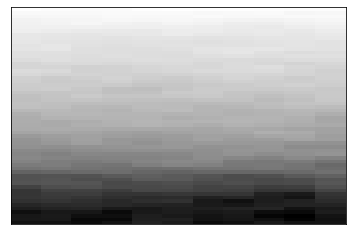

In [21]:
feature_strs = ['average_energy',
 'maximum_energy',
 'maximum_spectral-flux',
 'acoustic-complexity-index',
 'information-entropy',
 'maximum_weighted-phase-deviation',
 'maximum_pcen-flux_longdistance',
 'maximum_pcen-flux_birdvoxdetect',
 'maximum_pcen_longdistance',
 'maximum_pcen_birdvoxdetect']

bin_start = 40
bin_stop = 100

 #TODO: make bin_start:bin_stop exactly 1 kHz - 10 kHz
specshow(X_dict["average_energy"][bin_start:bin_stop, :], cmap='gray_r')

In [55]:
RGB = np.stack((
    X_dict["maximum_weighted-phase-deviation"],
    X_dict["maximum_pcen-flux_longdistance"],
    X_dict["maximum_pcen-flux_birdvoxdetect"]
), axis=-1);

In [57]:
R = deepcopy(RGB)[:, :];
R[:, :, 1] = 0;
R[:, :, 2] = 0;

G = deepcopy(RGB);
G[:, :, 0] = 0;
G[:, :, 2] = 0;

B = deepcopy(RGB);
B[:, :, 0] = 0;
B[:, :, 1] = 0;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


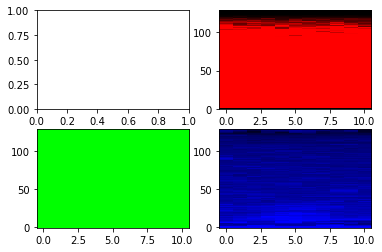

In [60]:
fig, ax = plt.subplots(ncols=2, nrows=2)

ax[0,1].imshow(R, aspect="auto", origin="lower")
ax[1,0].imshow(G, aspect="auto", origin="lower")
ax[1,1].imshow(B, aspect="auto", origin="lower")

In [56]:
aspect ratio

(129, 11, 3)